## Demo 3: sparse inverse covariance estimation
Today, we will learn how to learn a network that encodes conditional independence relationships from data. When we assume that the data comes from MVN, this amounts to the estimation of the inverse covariance matrice. We will use the [sklearn.covariance](https://scikit-learn.org/stable/modules/covariance.html#covariance) package to gain intuition about covariance estimation in synthetic data and in an empirical stock market data. 

### Goals:
1. Learn how to generate synthetic Gaussian samples and then use GraphicalLassoCV to infer its parameters.  
2. Learn how to use GraphicalLassoCV to find a graph structure from empirical data.

### Highlights:
* This DEMO is based on scikit-learn's [documentation](https://scikit-learn.org/stable/auto_examples/covariance/plot_sparse_cov.html#sphx-glr-auto-examples-covariance-plot-sparse-cov-py) about "Sparse inverse covariance estimation" and the [documentation](https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py) about "Visualizing the stock market structure." 

### Further reading:
* The [skggm](https://skggm.github.io/skggm/tour) package contains some modern algorithms such as QUIC to optimize the graphical lasso program. However, its API to Scikit-learn is outdated.


## Synthetic data: Sparse inverse covariance estimation

In [1]:
import sys
import numpy as np
import pandas as pd
from scipy import linalg
from sklearn import manifold
from sklearn import cluster
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

### Generate the synthetic data


In [2]:
n_samples = 60
n_features = 20

prng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(
    n_features, alpha=0.98, smallest_coef=0.4, largest_coef=0.7, random_state=prng
)
cov = linalg.inv(prec)
d = np.sqrt(np.diag(cov))
cov /= d
cov /= d[:, np.newaxis]
prec *= d
prec *= d[:, np.newaxis]
X = prng.multivariate_normal(np.zeros(n_features), cov, size=n_samples)
X -= X.mean(axis=0)
X /= X.std(axis=0)

In [3]:
X.shape

(60, 20)

### Estimate the covariance

In [4]:
emp_cov = np.dot(X.T, X) / n_samples

model = GraphicalLassoCV()
model.fit(X)
cov_ = model.covariance_
prec_ = model.precision_

### Plot the results

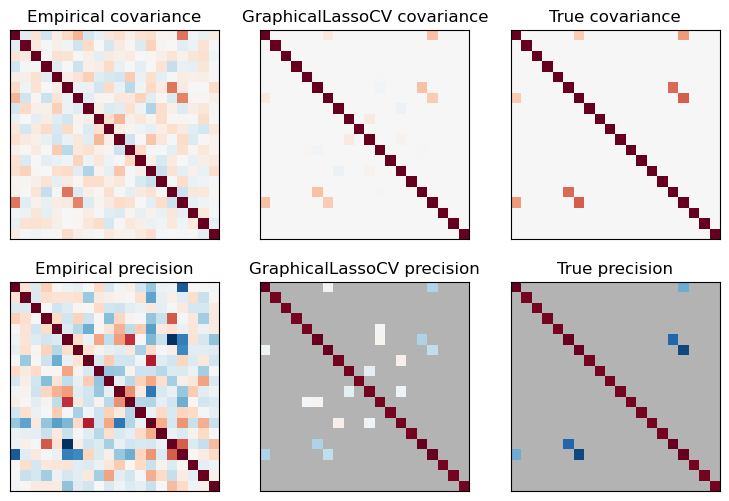

In [5]:
plt.figure(figsize=(10, 6))
plt.subplots_adjust(left=0.02, right=0.98)

# plot the covariances
covs = [
    ("Empirical", emp_cov),
    ("GraphicalLassoCV", cov_),
    ("True", cov),
]
vmax = cov_.max()
for i, (name, this_cov) in enumerate(covs):
    plt.subplot(2, 4, i + 1)
    plt.imshow(
        this_cov, interpolation="nearest", vmin=-vmax, vmax=vmax, cmap=plt.cm.RdBu_r
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s covariance" % name)


# plot the precisions
precs = [
    ("Empirical", linalg.inv(emp_cov)),
    ("GraphicalLassoCV", prec_),
    ("True", prec),
]
vmax = 0.9 * prec_.max()
for i, (name, this_prec) in enumerate(precs):
    ax = plt.subplot(2, 4, i + 5)
    plt.imshow(
        np.ma.masked_equal(this_prec, 0),
        interpolation="nearest",
        vmin=-vmax,
        vmax=vmax,
        cmap=plt.cm.RdBu_r,
    )
    plt.xticks(())
    plt.yticks(())
    plt.title("%s precision" % name)
    if hasattr(ax, "set_facecolor"):
        ax.set_facecolor(".7")
    else:
        ax.set_axis_bgcolor(".7")


### Plot the model selection metric

We can also use other model selection schemes, see, e.g., [this page](https://skggm.github.io/skggm/tour#a-tour-of-skggm--methods--interfaces).

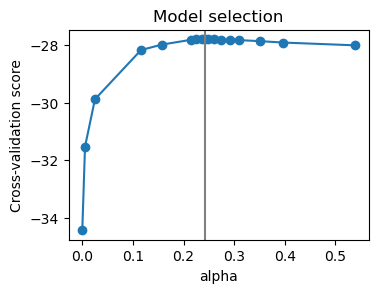

In [6]:
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

## Empirical data: Visualizing the stock market structure

This part is based on Gael Varoquaux's tutorial [here](https://scikit-learn.org/stable/auto_examples/applications/plot_stock_market.html#sphx-glr-auto-examples-applications-plot-stock-market-py).

This part will analyze the historical price data from 56 stocks and use Gaussian graphical modeling to find its graphical structure. You can envision that we can also use other APIs such as [Yahoo! Finance](https://pypi.org/project/yfinance/) to perform a similar analysis.


In [7]:
symbol_dict = {
    "TOT": "Total",
    "XOM": "Exxon",
    "CVX": "Chevron",
    "COP": "ConocoPhillips",
    "VLO": "Valero Energy",
    "MSFT": "Microsoft",
    "IBM": "IBM",
    "TWX": "Time Warner",
    "CMCSA": "Comcast",
    "CVC": "Cablevision",
    "YHOO": "Yahoo",
    "DELL": "Dell",
    "HPQ": "HP",
    "AMZN": "Amazon",
    "TM": "Toyota",
    "CAJ": "Canon",
    "SNE": "Sony",
    "F": "Ford",
    "HMC": "Honda",
    "NAV": "Navistar",
    "NOC": "Northrop Grumman",
    "BA": "Boeing",
    "KO": "Coca Cola",
    "MMM": "3M",
    "MCD": "McDonald's",
    "PEP": "Pepsi",
    "K": "Kellogg",
    "UN": "Unilever",
    "MAR": "Marriott",
    "PG": "Procter Gamble",
    "CL": "Colgate-Palmolive",
    "GE": "General Electrics",
    "WFC": "Wells Fargo",
    "JPM": "JPMorgan Chase",
    "AIG": "AIG",
    "AXP": "American express",
    "BAC": "Bank of America",
    "GS": "Goldman Sachs",
    "AAPL": "Apple",
    "SAP": "SAP",
    "CSCO": "Cisco",
    "TXN": "Texas Instruments",
    "XRX": "Xerox",
    "WMT": "Wal-Mart",
    "HD": "Home Depot",
    "GSK": "GlaxoSmithKline",
    "PFE": "Pfizer",
    "SNY": "Sanofi-Aventis",
    "NVS": "Novartis",
    "KMB": "Kimberly-Clark",
    "R": "Ryder",
    "GD": "General Dynamics",
    "RTN": "Raytheon",
    "CVS": "CVS",
    "CAT": "Caterpillar",
    "DD": "DuPont de Nemours",
}


symbols, names = np.array(sorted(symbol_dict.items())).T

quotes = []

for symbol in symbols:
    # print(f"Fetching quote history for {symbol}", file=sys.stderr)
    url = (
        "https://raw.githubusercontent.com/scikit-learn/examples-data/"
        "master/financial-data/{}.csv"
    )
    quotes.append(pd.read_csv(url.format(symbol)))

close_prices = np.vstack([q["close"] for q in quotes])
open_prices = np.vstack([q["open"] for q in quotes])

# The daily variations of the quotes are what carry the most information
variation = close_prices - open_prices

In [8]:
variation.shape

(56, 1258)

### Learning a graph structure
GraphicalLassoCV is so nicely wrapped that it is all we need to fit the Graphical LASSO model.

In [9]:
alphas = np.logspace(-1.5, 1, num=10)
mvn_model = GraphicalLassoCV(alphas=alphas)

# standardize the time series: using correlations rather than covariance
# former is more efficient for structure recovery
X = variation.copy().T
X /= X.std(axis=0)
mvn_model.fit(X)

GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

### Use affinity propagation to find clusters
Note: this is not necessary for Graphical LASSO, but a useful step to add labels to our visualization later.

In [10]:
_, labels = cluster.affinity_propagation(mvn_model.covariance_, random_state=0)
n_labels = labels.max()

for i in range(n_labels + 1):
    print(f"Cluster {i + 1}: {', '.join(names[labels == i])}")

Cluster 1: Apple, Amazon, Yahoo
Cluster 2: Comcast, Cablevision, Time Warner
Cluster 3: ConocoPhillips, Chevron, Total, Valero Energy, Exxon
Cluster 4: Cisco, Dell, HP, IBM, Microsoft, SAP, Texas Instruments
Cluster 5: Boeing, General Dynamics, Northrop Grumman, Raytheon
Cluster 6: AIG, American express, Bank of America, Caterpillar, CVS, DuPont de Nemours, Ford, General Electrics, Goldman Sachs, Home Depot, JPMorgan Chase, Marriott, McDonald's, 3M, Ryder, Wells Fargo, Wal-Mart
Cluster 7: GlaxoSmithKline, Novartis, Pfizer, Sanofi-Aventis, Unilever
Cluster 8: Kellogg, Coca Cola, Pepsi
Cluster 9: Colgate-Palmolive, Kimberly-Clark, Procter Gamble
Cluster 10: Canon, Honda, Navistar, Sony, Toyota, Xerox


### Embedding in 2D space
Note: this is also not necessary for Graphical LASSO, but a useful step to find nicely looking locations of the nodes in our visualization later.

In [11]:
node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

### Visualization

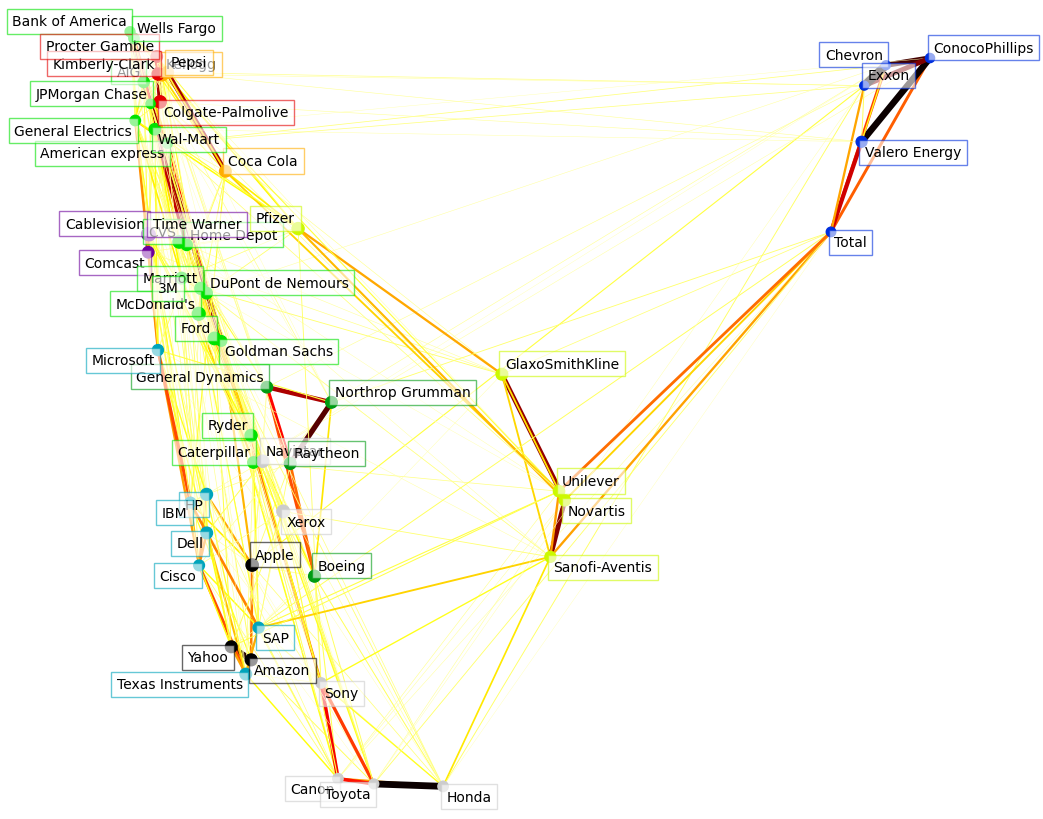

In [12]:

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")

# Plot the graph of partial correlations
partial_correlations = mvn_model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02

# Plot the nodes using the coordinates of our embedding
_s = 100 * d**2
plt.scatter(
    embedding[0], embedding[1], s=_s, c=labels, cmap=plt.cm.nipy_spectral
)

# Plot the edges
start_idx, end_idx = np.where(non_zero)
# a sequence of (*line0*, *line1*, *line2*), where::
#            linen = (x0, y0), (x1, y1), ... (xm, ym)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

# Add a label to each node. The challenge here is that we want to
# position the labels to avoid overlap with other labels
for index, (name, label, (x, y)) in enumerate(zip(names, labels, embedding.T)):

    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * embedding[0].ptp(),
    embedding[0].max() + 0.10 * embedding[0].ptp(),
)
plt.ylim(
    embedding[1].min() - 0.03 * embedding[1].ptp(),
    embedding[1].max() + 0.03 * embedding[1].ptp(),
)

plt.show()